In [5]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import (
    RandomForestClassifier,
    StackingClassifier,
    GradientBoostingClassifier
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import joblib

In [56]:
#load and then find features with gini importance
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

df = pd.read_csv('df_cluster_3.csv')

X_all = df.drop(['Cluster','Bankrupt?','Index'], axis=1)
y     = df['Bankrupt?']

#RF to get importances
rf_sel = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_sel.fit(X_all, y)

#top 10 by gini importance
feat_imp = rf_sel.feature_importances_
feat_df = (
    pd.DataFrame({'feature': X_all.columns, 'importance': feat_imp})
      .sort_values('importance', ascending=False)
)
top10 = feat_df['feature'].iloc[:10].tolist()

print("Using these 10 features:")
for f in top10:
    print(" •", f)

#reduce X to exactly those 10
X = X_all[top10].copy()
print("\nX now has shape:", X.shape)


Using these 10 features:
 •  Total debt/Total net worth
 •  Degree of Financial Leverage (DFL)
 •  ROA(C) before interest and depreciation before interest
 •  Net Value Growth Rate
 •  Tax rate (A)
 •  Cash flow rate
 •  Current Ratio
 •  Total expense/Assets
 •  Realized Sales Gross Profit Growth Rate
 •  Operating Gross Margin

X now has shape: (2207, 10)


In [57]:
def train_and_eval(pipe, X, y):
    """
    Fit on full training data and evaluate on the same data.
    Returns (cm, tp, fn, acc, proba_vector).
    """
    pipe.fit(X, y)
    proba = pipe.predict_proba(X)[:, 1]
    preds = (proba > 0.5).astype(int)
    cm = confusion_matrix(y, preds)
    tn, fp, fn, tp = cm.ravel()
    acc = tp / (tp + fn) if (tp + fn) > 0 else 1.0
    return cm, tp, fn, acc, proba

def plot_confusion(cm, title):
    """
    Plot a confusion matrix heatmap inline.
    """
    fig, ax = plt.subplots(figsize=(4, 4))
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar(cax)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Pred 0', 'Pred 1'])
    ax.set_yticks([0, 1])
    ax.set_yticklabels(['Actual 0', 'Actual 1'])
    for (i, j), value in np.ndenumerate(cm):
        ax.text(j, i, str(value), ha='center', va='center', color='red')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    plt.tight_layout()
    plt.show()

In [53]:
#print data aggin to see
print(f"Cluster 3: {X.shape[0]} samples, {X.shape[1]} features")
print(f"Bankruptcies (y=1): {y.sum()} ({y.mean():.2%})\n")

Cluster 3: 2207 samples, 8 features
Bankruptcies (y=1): 70 (3.17%)



In [58]:
#define base models and hyperparameter grids
base_specs = {
    'RandomForest': {
        'estimator': RandomForestClassifier(class_weight='balanced', random_state=42),
        'params': {
            'clf__n_estimators': [100, 200],
            'clf__max_depth': [None, 10, 20]
        }
    },
    'DecisionTree': {
        'estimator': DecisionTreeClassifier(class_weight='balanced', random_state=42),
        'params': {
            'clf__max_depth': [None, 5, 10],
            'clf__min_samples_split': [2, 5, 10]
        }
    },
    'GradientBoosting': {
        'estimator': GradientBoostingClassifier(random_state=42),
        'params': {
            'clf__n_estimators': [100, 200],
            'clf__learning_rate': [0.01, 0.1],
            'clf__max_depth': [3, 5]
        }
    },
    'KNN1': {
        # 1-NN will perfectly memorize the training set
        'estimator': KNeighborsClassifier(n_neighbors=1),
        'params': {}
    }
}

meta_features = {}
trained_models = {}

--- RandomForest ---
Best params: {'clf__max_depth': 10, 'clf__n_estimators': 100}
TT(tp) = 70, TF(fn) = 0, acc = 1.0000
Confusion matrix:
[[2112   25]
 [   0   70]]


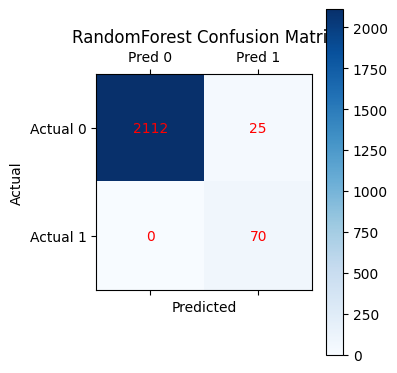

--- DecisionTree ---
Best params: {'clf__max_depth': None, 'clf__min_samples_split': 2}
TT(tp) = 70, TF(fn) = 0, acc = 1.0000
Confusion matrix:
[[2137    0]
 [   0   70]]


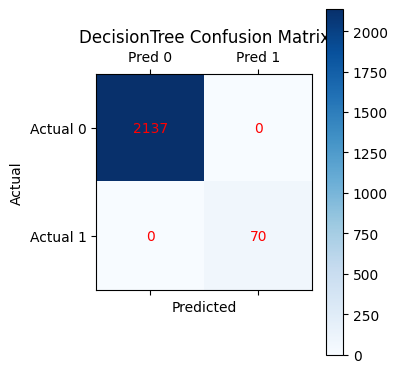

--- GradientBoosting ---
Best params: {'clf__learning_rate': 0.01, 'clf__max_depth': 5, 'clf__n_estimators': 100}
TT(tp) = 40, TF(fn) = 30, acc = 0.5714
Confusion matrix:
[[2137    0]
 [  30   40]]


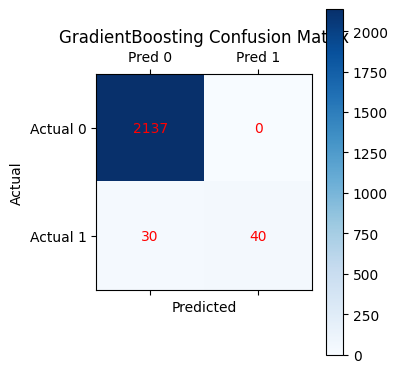

--- KNN1 ---
TT(tp) = 70, TF(fn) = 0, acc = 1.0000
Confusion matrix:
[[2137    0]
 [   0   70]]


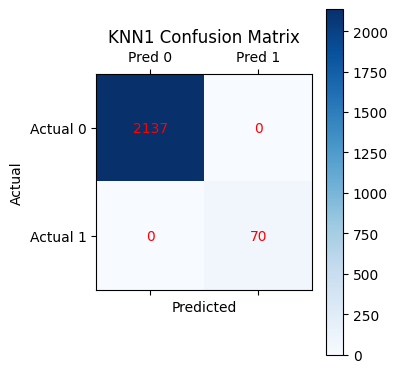

In [59]:
#tune and train on full data
for name, spec in base_specs.items():
    print(f"--- {name} ---")
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', spec['estimator'])
    ])

    if spec['params']:
        grid = GridSearchCV(
            estimator=pipe,
            param_grid=spec['params'],
            cv=3,
            scoring='accuracy',
            n_jobs=-1
        )
        grid.fit(X, y)
        best_pipe = grid.best_estimator_
        print("Best params:", grid.best_params_)
    else:
        best_pipe = pipe

    #train and evaluate on same data
    cm, tp, fn, acc, proba = train_and_eval(best_pipe, X, y)
    print(f"TT(tp) = {tp}, TF(fn) = {fn}, acc = {acc:.4f}")
    print("Confusion matrix:")
    print(cm)

    plot_confusion(cm, title=f"{name} Confusion Matrix")

    joblib.dump(best_pipe, f'cluster3_{name.lower()}_model.joblib')

    trained_models[name] = best_pipe
    meta_features[name] = proba


=== Stacking Meta-Model on TRAINING ===
TT(tp) = 70, TF(fn) = 0, acc = 1.0000
Overall stacking confusion matrix:
[[2137    0]
 [   0   70]]


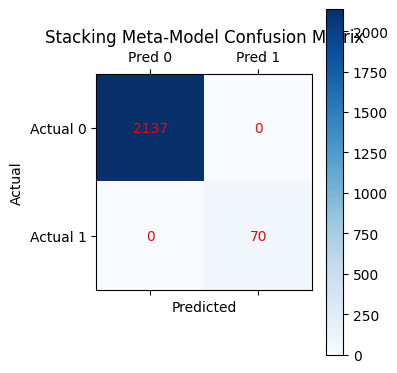

In [60]:
#build and evaluate stacking meta-model on full data
meta_df = pd.DataFrame(meta_features)
estimators = [(n, trained_models[n]) for n in trained_models]
stack = StackingClassifier(
    estimators=estimators,
    final_estimator=DecisionTreeClassifier(random_state=42),
    passthrough=False,
    cv=3,
    n_jobs=-1
)
stack.fit(meta_df, y)
proba_meta = stack.predict_proba(meta_df)[:, 1]
preds_meta = (proba_meta > 0.5).astype(int)
cm_meta = confusion_matrix(y, preds_meta)
tn, fp, fn, tp = cm_meta.ravel()
acc_meta = tp / (tp + fn) if (tp + fn) > 0 else 1.0

print("\n=== Stacking Meta-Model on TRAINING ===")
print(f"TT(tp) = {tp}, TF(fn) = {fn}, acc = {acc_meta:.4f}")
print("Overall stacking confusion matrix:")
print(cm_meta)

plot_confusion(cm_meta, title="Stacking Meta-Model Confusion Matrix")

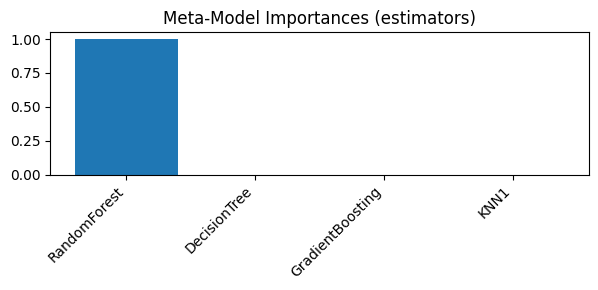

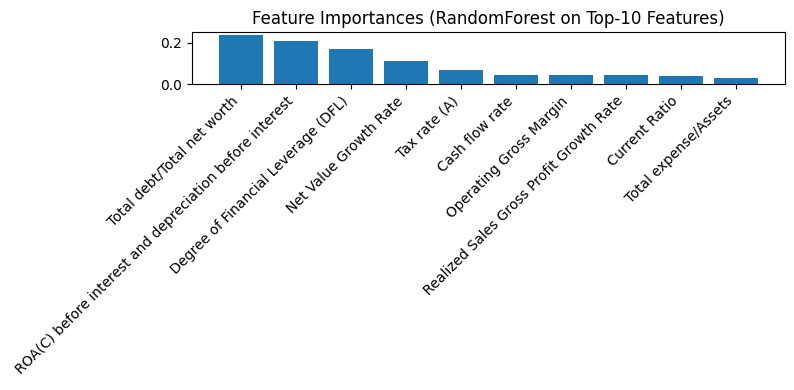

In [61]:
#meta-model feature importances
plt.figure(figsize=(6, 3))
importances = stack.final_estimator_.feature_importances_
plt.bar(meta_df.columns, importances)
plt.title('Meta-Model Importances (estimators)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#plot importances for final rf model on top-10 features
rf_clf = trained_models['RandomForest'].named_steps['clf']
feat_imp = rf_clf.feature_importances_
feat_df = (
    pd.DataFrame({'feature': X.columns, 'importance': feat_imp})
    .sort_values('importance', ascending=False)
    .head(10)
)
plt.figure(figsize=(8, 4))
plt.bar(feat_df['feature'], feat_df['importance'])
plt.title('Feature Importances (RandomForest on Top-10 Features)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [62]:
report = {
    'Member':        'Jack Gibson',
    'Cluster':       3,
    'TT_meta':       int(tp),
    'TF_meta':       int(fn),
    'acc_meta':      round(acc_meta, 4),
    'N_features':    X.shape[1],         # should now be 10
    'Base_models':   list(base_specs.keys()),
    'Top10_features': top10              # your selected 10
}

print("\n=== Final Report for Cluster 3 ===")
for k, v in report.items():
    print(f"{k}: {v}")



=== Final Report for Cluster 3 ===
Member: Jack Gibson
Cluster: 3
TT_meta: 70
TF_meta: 0
acc_meta: 1.0
N_features: 10
Base_models: ['RandomForest', 'DecisionTree', 'GradientBoosting', 'KNN1']
Top10_features: [' Total debt/Total net worth', ' Degree of Financial Leverage (DFL)', ' ROA(C) before interest and depreciation before interest', ' Net Value Growth Rate', ' Tax rate (A)', ' Cash flow rate', ' Current Ratio', ' Total expense/Assets', ' Realized Sales Gross Profit Growth Rate', ' Operating Gross Margin']
